In [21]:
import QpixAsicArray as qparray
from QpixAsic import PixelHit, ProcQueue
import random
import numpy as np
random.seed(2)
diffs, std_diffs = [], []
frqs = np.arange(1,16)*1e-5

In [22]:
# timeNow = 1.
# timeEnd = 4.0
# tickNow = 50e6
# deltaT = 1.0
# deltaTick = 50e6
# timeEpsilon = 1e-6
# eventTimes = []
# hitsPerEvent, eventTimes = [], []
# procQueue = ProcQueue()
    
# while(timeNow < timeEnd):

#     items = 0
#     topProc = []
#     midProc = []
#     botProc = []
#     lenRecv = []
#     asicRow = []
#     asicCol = []

#     for asic in qpa:
#         newProcessItems = asic.Process(timeNow - timeEpsilon)
#         if newProcessItems:
#             print("WARNING: ASIC had things left to do at next maor time step")

#     procQueue.AddQueueItem(qpa[0][0], 3, PixelHit(tickNow, [], None, None), timeNow)

#     while(procQueue.Length() > 0):

#         nextItem = procQueue.PopQueue()
#         items += 1

#         topProc.append(qpa.ProcessArray(procQueue, nextItem.inTime))

#         newProcessItems = nextItem.asic.ReceiveData(nextItem)
#         if newProcessItems:
#             midProc.append(1)
#             lenRecv.append(len(newProcessItems))
#             for item in newProcessItems:
#                 procQueue.AddQueueItem(*item)
#         else:
#             midProc.append(0)
#             lenRecv.append(0)

#         botProc.append(qpa.ProcessArray(procQueue, nextItem.inTime))

#     eventTimes.append(qpa._daqNode._absTimeNow-timeNow)
#     hitsPerEvent.append(qpa._daqNode.daqHits)
#     qpa._daqNode.daqHits = 0
#     timeNow += deltaT
#     tickNow += deltaTick
#     # print("ran through this many items:", items)
#     # print('topProc:', np.sum(topProc), len(topProc), topProc[:20])
#     # print('midProc:  ', np.sum(midProc), len(midProc), midProc[:20])
#     # print('botProc:  ', np.sum(botProc), len(botProc), botProc[:20])
#     # print('lenRecv:  ', np.sum(lenRecv), len(lenRecv), lenRecv[:20])
#     # print('sum:', items-np.sum(topProc+midProc+botProc))

In [23]:
for frq in frqs:
    qpa = qparray.QpixAsicArray(4, 4, debug=0.0, deltaT=10e-6)
    qpa._daqNode._debugLevel = 0
    qpa.Calibrate(frq)
    qpa.Calibrate(frq)
    print(qpa._daqNode.daqHits)
    guessFrq = {}
    daqTicks, asicTicks = [], []
    frq_diffs = []
    for i, (k, v) in enumerate(qpa._daqNode.pixelData.items()):
        asic = k
        # print(asic)
        daqTicks.append([])
        asicTicks.append([])
        for daqTick, asicTick in v:
            daqTicks[i].append(daqTick)
            asicTicks[i].append(asicTick)
        guessFrq[asic] = (asicTicks[i][1] - asicTicks[i][0]) / (daqTicks[i][1] - daqTicks[i][0])  * qpa._daqNode.fOsc
    for asic in qpa:
        key = f"({asic.row},{asic.col})"
        diff = (guessFrq[key] - asic.fOsc) / asic.fOsc * 100
        frq_diffs.append(diff)
        #print(f"{key} percent diff: {diff}")
    diffs.append(np.mean(frq_diffs))
    std_diffs.append(np.std(frq_diffs))

performing calibration..
calibration complete in 98 steps!
calibration broadcast complete at: 1e-05
performing calibration..
calibration complete in 98 steps!
calibration broadcast complete at: 2e-05
32
performing calibration..
calibration complete in 99 steps!
calibration broadcast complete at: 2e-05
performing calibration..
calibration complete in 99 steps!
calibration broadcast complete at: 4e-05
32
performing calibration..
calibration complete in 100 steps!
calibration broadcast complete at: 3.0000000000000004e-05
performing calibration..
calibration complete in 101 steps!
calibration broadcast complete at: 7.000000000000001e-05
32
performing calibration..
calibration complete in 101 steps!
calibration broadcast complete at: 4e-05
performing calibration..
calibration complete in 101 steps!
calibration broadcast complete at: 8e-05
32
performing calibration..
calibration complete in 102 steps!
calibration broadcast complete at: 5e-05
performing calibration..
calibration complete in 1

In [24]:
print(diffs)

[161.48985060803437, 105.95855890691864, 73.92507932285481, 52.83587796812495, 36.94241272749055, 4.66162173441611, 15.486747893617434, 0.6400610708294616, -0.0005223423758360778, -0.0013404195374800637, -0.0010649761289035099, 0.0007322817020159565, 5.6856181685899275e-05, 0.00077300156176532, -0.0019620342389345415]


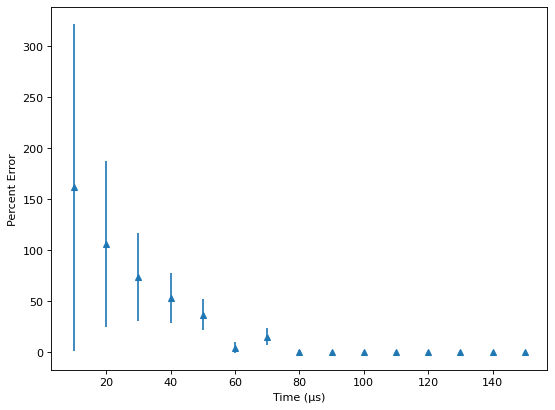

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(frqs*1e6, diffs, std_diffs, linestyle='None', marker='^')
plt.xlabel(u"Time (\u03bcs)")
plt.ylabel("Percent Error")
plt.savefig("test.png")